## Action-angle variables

Reading material:
- Anything on Hamiltonian mechanics, in particular, canonical transformations;
- Binney & Tremaine chapter 3.5 (more detailed but slightly outdated in that it does not cover recent developments, e.g. Stäckel fudge);
- Bovy's book, chapters [4.4](https://galaxiesbook.org/chapters/I-03.-Orbits-in-Spherical-Mass-Distributions_4-Actions-and-angles-in-spherical-potentials.html) and [9.4](https://galaxiesbook.org/chapters/II-03.-Orbits-in-Disks_4-Action-angle-coordinates-in-and-around-disks.html);
- [Sanders & Binney](http://adsabs.harvard.edu/abs/2016MNRAS.457.2107S)'s review of action computation methods.

In [1]:
import agama, numpy, scipy.integrate, scipy.optimize, scipy.special, time, matplotlib, matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', dpi = 75)
plt.rc('mathtext', fontset='stix')

General motivation: make the equations of motion as simple as possible – namely, those of a free particle.

Recall the general formalism of canonical transformations $\{\boldsymbol q, \boldsymbol p\} \Leftrightarrow \{\boldsymbol Q, \boldsymbol P\}$. Starting from some standard phase-space coordinates $\{\boldsymbol q, \boldsymbol p\}$ (e.g. Cartesian or spherical), transform to the new ones such that the Hamiltonian becomes $H(\boldsymbol Q, \boldsymbol P) = H(\boldsymbol P)$. Then from Hamilton's equations we get $\;\boldsymbol P(t) = \text{const}\;$ and $\;\boldsymbol Q(t) = \frac{\partial H}{\partial \boldsymbol P}t + \text{const}$, i.e. motion along a straight line.<br>
Of course, we are rather interested in bound orbits, so the motion should be (multi)periodic – adopt an equivalence $\boldsymbol Q + 2\pi \boldsymbol n \equiv \boldsymbol Q$.<br>
The naming convention is to denote the new coordinates $\boldsymbol Q$ as angles $\boldsymbol \theta$, and the new momenta $\boldsymbol P$ as actions $\boldsymbol J$.

### Actions in 1d systems

Simplest example: 1d harmonic oscillator.<br>
Hamiltonian $H(q,p) = \frac{1}{2} \omega^2 q^2 + \frac{1}{2} p^2$.<br>
Solution of the equations of motion:  $q(t) = A\,\sin(\omega t + \phi_0),\; p(t) = A\,\omega\,\cos(\omega t + \phi_0);\;$  total energy: $E=\frac{1}{2}\omega^2 A^2$.

The motion is periodic with period $2\pi/\omega$ (where $\omega$ is the frequency), so we define the angle $\theta = \omega t + \phi_0$.<br>
The action is $J = \frac{1}{2\pi} \oint p\, {\text d}q$, i.e. <u>the area enclosed by the orbit divided by $2\pi$</u> (this is true for any 1d system), and it works out to be $J = E/\omega$ (this is true only for the harmonic potential, but a general expression is that the frequency is $\Omega = \text{d}H / \text{d}J$).

A slightly more complicated example below: motion in a 1d quartic potential<br>
$H(q,p) = \frac{K}{4} q^4 + \frac{1}{2} p^2$.<br>
**Exercise:** show that in this case $J = \frac{2\sqrt{2\pi}}{3\,\Gamma(3/4)^2 K^{1/4}} E^{3/4}$ and $\Omega = \frac{\sqrt{2}\,\Gamma(3/4)^2 K^{1/4}}{\sqrt{\pi}} E^{1/4}$.<br>
Note that here the period gets shorter with increasing energy, but in all realistic galactic potentials, it is the opposite – less bound orbits have longer periods.

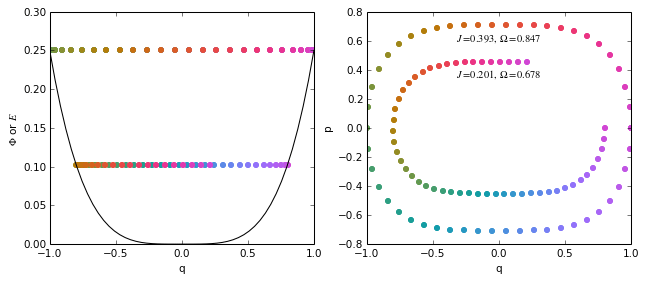

In [2]:
K = 1.0
def pot(q):
    return K/4 * q**4

def fnc(x, t):
    q,p = x
    return (p, -K * q**3)  # dq/dt = dH/dp, dp/dt = -dH/dq  (Hamilton's eqs)

def show_orbit(ic, time=None):
    E = pot(ic[0]) + 0.5 * ic[1]**2
    xmax = (4 * E / K)**(1./4)
    # analytic expressions for J and Omega
    J = 2 * (2*numpy.pi)**0.5 / (scipy.special.gamma(3./4)**2 * K**(1./4) * 3) * E**(3./4)
    Omega = (2/numpy.pi)**0.5 *  scipy.special.gamma(3./4)**2 * K**(1./4) * E**(1./4)
    if time is None:
        time = 2*numpy.pi / Omega  # 1 period
    times = numpy.linspace(0, time, 51)
    sol = scipy.integrate.odeint(fnc, ic, times)
    for t, (q,p) in zip(times, sol):
        color = cmap(t / time)
        ax[0].plot(q, pot(q) + 0.5*p**2, 'o', mew=0, color=color)
        ax[1].plot(q, p, 'o', mew=0, color=color)
    def action_integrand(q):
        return (2 * (E-pot(q)))**0.5
    Jnum = scipy.integrate.quad(action_integrand, 0, xmax)[0] * 2 / numpy.pi
    assert abs(J/Jnum-1) < 1e-10   # sanity check
    return J, Omega

ax = plt.subplots(1, 2, figsize=(10, 4))[1]
cmap = plt.get_cmap('circle')
J1, Omega1 = show_orbit([1.0, 0.0])
J2, Omega2 = show_orbit([0.8, 0.0], 2*numpy.pi / Omega1)
ax[1].text(0, 0.60, r'$J=%.3f,\,\Omega=%.3f$' % (J1, Omega1), ha='center')
ax[1].text(0, 0.35, r'$J=%.3f,\,\Omega=%.3f$' % (J2, Omega2), ha='center')
qq = numpy.linspace(-1, 1)
ax[0].plot(qq, pot(qq), 'k')
ax[0].set_xlabel('q')
ax[1].set_xlabel('q')
ax[0].set_ylabel(r'$\Phi$ or $E$')
ax[1].set_ylabel('p')
None

### Actions for planar orbits in a 2d axisymmetric potential

$\Phi(x,y) = \Phi(R)$; use the polar coordinates $\boldsymbol q = \{R,\varphi\}$ and canonically conjugate momenta $\boldsymbol p = \{p_R, p_\varphi\}$, where $p_R = \dot R$ is the radial velocity and $p_\varphi = R^2\dot\varphi = L$ is the angular momentum (conserved because the Hamiltonian does not depend on $\varphi$).

Motion in $R$ is described by the effective potential $\Phi_\text{eff} \equiv \Phi(R) + \frac{1}{2}(p_\varphi/R)^2$. The radius at which it reaches minumum is called the *guiding radius* $R_g$.<br> 
The radial action is $J_R = \frac{1}{\pi} \int_{R_-}^{R_+} p_R\,\text{d}R = \frac{1}{\pi} \int_{R_-}^{R_+} \sqrt{2[E-\Phi_\text{eff}(R)]}\,\text{d}R$, where $R_\pm$ are the peri/apocenter radii (roots of $\Phi_\text{eff}(R_\pm)=E$).<br>
The azimuthal action $J_\varphi$ is just the angular momentum $L$ (= the canonical momentum $p_\varphi$).

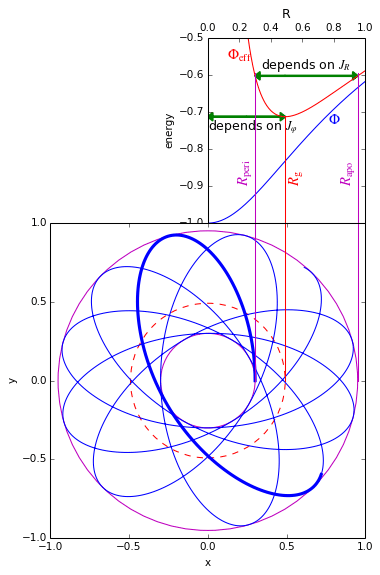

In [3]:
pot = agama.Potential(type='isochrone', scaleradius=0.5)
ic = numpy.array([0.3, 0, 0, 0, 0.8, 0])
_,orb = agama.orbit(potential=pot, ic=ic, time=50, trajsize=1001)
plt.figure(figsize=(5,7.5))
ax2 = plt.axes([0.52, 0.61, 0.42, 0.33])
ax1 = plt.axes([0.10, 0.05, 0.84, 0.56])
ax1.plot(orb[:,0], orb[:,1], c='b')
ax1.plot(orb[:150,0], orb[:150,1], c='b', lw=3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
r = numpy.linspace(0, 1, 201)[1:]
L = ic[0] * ic[4] - ic[1] * ic[3]
E = pot.potential(ic[0:3]) + 0.5 * sum(ic[3:6]**2)
Phi = pot.potential(numpy.column_stack([r, r*0, r*0]))
Phieff = Phi + 0.5 * (L/r)**2
# guiding radius; note that it differs from the radius of a circular orbit with the given energy, Rcirc(E=E)
Rg = pot.Rcirc(L=L)
Eg = pot.potential(Rg,0,0) + 0.5 * (L/Rg)**2  # effective potential at R=Rg
# peri/apocenter radii of a planar orbit with the given E,L or 6d initial conditions
Rperi, Rapo = pot.Rperiapo(ic)
ax1.plot([Rperi, Rperi], [0, 1.95], color='m', clip_on=False)
ax1.plot([Rapo,  Rapo ], [0, 1.95], color='m', clip_on=False)
ax1.plot([Rg,    Rg   ], [0, 1.68], color='r',  clip_on=False)
ax1.add_artist(matplotlib.patches.Circle((0,0), Rperi, color='m', fill=False))
ax1.add_artist(matplotlib.patches.Circle((0,0), Rapo,  color='m', fill=False))
ax1.add_artist(matplotlib.patches.Circle((0,0), Rg,    color='r', fill=False, ls='dashed'))
ax2.plot(r, Phi, c='b')
ax2.plot(r, Phieff, c='r')
ax2.text(0.8, -0.72, r'$\Phi$', ha='center', va='center', fontsize=14, color='b')
ax2.text(0.2, -0.55, r'$\Phi_{\rm eff}$', ha='center', va='center', fontsize=14, color='r')
ax2.set_xlim(0, 1)
ax2.set_ylim(-1,-0.5)
ax2.set_ylabel('energy')
ax2.arrow(Rg, E, Rperi-Rg, 0, color='g', lw=2, length_includes_head=True)
ax2.arrow(Rg, E, Rapo -Rg, 0, color='g', lw=2, length_includes_head=True)
ax2.text((Rperi+Rapo)/2, E+0.005, 'depends on $J_R$', fontsize=12, ha='center', va='bottom')
ax2.arrow(Rg/2, Eg, Rg/2, 0, color='g', lw=2, length_includes_head=True)
ax2.arrow(Rg/2, Eg,-Rg/2, 0, color='g', lw=2, length_includes_head=True)
ax2.text(0, Eg-0.005, r'depends on $J_\varphi$', fontsize=12, ha='left', va='top')
ax2.text(Rperi, -0.9, r'$R_{\rm peri}$', ha='right', va='bottom', rotation=90, color='m', fontsize=14)
ax2.text(Rapo,  -0.9, r'$R_{\rm apo}$',  ha='right', va='bottom', rotation=90, color='m', fontsize=14)
ax2.text(Rg+.02,-0.9, r'$R_{\rm g}$',    ha='left',  va='bottom', rotation=90, color='r', fontsize=14)
ax2.xaxis.tick_top()
ax2.set_title('R', y=1.08)
None

Note that while the radius $R$ and the radial phase angle $\theta_R$ are uniquely related to each other, this is not true for the azimuthal angle $\varphi$ and the corresponding phase angle $\theta_\varphi$. The latter increases linearly with time by definition, while the former increases faster when the radius is smaller, since $\dot\varphi = p_\phi / R^2$. Only **on average** $\varphi$ increases by $2\pi$ during one azimuthal period $T_\varphi \equiv 2\pi/\Omega_\phi$.

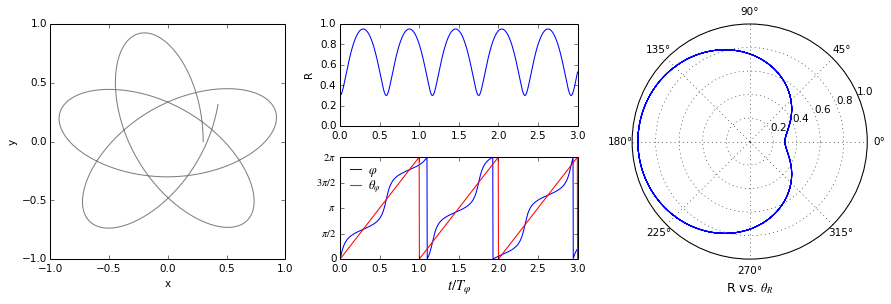

In [4]:
trad,_,tphi = 2*numpy.pi/agama.actions(potential=pot, point=ic, actions=False, angles=False, frequencies=True)
periods = 3.0  # integration time in units of azimuthal period tphi
tim,orb = agama.orbit(potential=pot, ic=ic, time=periods*tphi, trajsize=1001)
tim /= tphi
r   = (orb[:,0]**2+orb[:,1]**2)**0.5
phi = numpy.unwrap(numpy.arctan2(orb[:,1], orb[:,0]))
ang = agama.actions(potential=pot, point=orb, actions=False, angles=True, frequencies=False)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(2,3,(1,4), aspect='equal')
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,5, sharex=ax2)
ax4 = fig.add_subplot(2,3,(3,6), projection='polar')
ax1.plot(orb[:,0], orb[:,1], color='gray')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.plot(tim, r, c='b')
ax3.plot(tim, phi % (2*numpy.pi), c='b', label=r'$\varphi$')
ax3.plot(tim, ang[:,2], c='r', label=r'$\theta_\varphi$')
ax4.plot(ang[:,0], r, c='b')
ax2.set_xlim(0, periods)
ax2.set_ylim(0, 1)
ax2.set_ylabel('R')
ax3.set_xlabel(r'$t / T_\varphi$', fontsize=14)
ax3.set_ylim(0, 2*numpy.pi)
ax3.set_yticks(numpy.linspace(0, 2*numpy.pi, 5))
ax3.set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax4.set_xlabel(r'R vs. $\theta_R$', fontsize=12)
ax3.legend(loc='upper left', frameon=False, handlelength=1.5, handletextpad=0.2, labelspacing=0, borderpad=0, fontsize=12)
plt.tight_layout()
None

### Actions in a 3d spherical potential

$\Phi(x,y,z) = \Phi(r)$; use the spherical coordinates $\boldsymbol q = \{r,\vartheta,\varphi\}$ and canonically conjugate momenta $\boldsymbol p = \{p_r, p_\vartheta, p_\varphi\}$, where $p_r = \dot r$, $p_\vartheta = r^2\dot\vartheta$ and $p_\varphi = (r\,\sin\vartheta)^2\dot\varphi = L_z$. The total angular momentum is $L = \sqrt{p_\vartheta^2 + p_\varphi^2}$.

As before, motion in $r$ is described by the effective potential $\Phi_\text{eff} \equiv \Phi(r) + \frac{1}{2}(L/r)^2$, the peri/apocenter radii are given by $\Phi_\text{eff}(r_\pm)=E$, and the radial action is $J_r = \frac{1}{\pi} \int_{r_-}^{r_+} p_r\,\text{d}r = \frac{1}{\pi} \int_{r_-}^{r_+} \sqrt{2[E-\Phi_\text{eff}(r)]}\,\text{d}r$. The azimuthal action $J_\varphi$ is still equal to $L_z$, while the vertical action is $J_\vartheta = L - |L_z|$.<br>
The frequencies associated with the oscillations in $\vartheta$ and $\varphi$ are identical; equivalently, the orbital plane does not precess.

In a general spherical potential, expressions for radial action and all frequencies and angles contain 1d integrals evaluated numerically. An exception is the `Isochrone` potential (Hénon 1959): $\Phi(r) = -\frac{GM}{b + \sqrt{b^2+r^2}}$, including its limiting cases (Kepler and harmonic oscillator), in which $J_r = \frac{GM}{\sqrt{-2E}} - \frac{1}{2}\left(L + \frac{1}{2}\sqrt{L^2 + 4G M b}\right)$. The inverse mapping from $\{\boldsymbol J, \boldsymbol \theta\}$ to $\{\boldsymbol p, \boldsymbol q\}$ is also analytic for the `Isochrone` potential, but involves solving the Kepler equation $\theta = \eta - e \sin\eta$.

In `Agama`, the conversion between $\{E,L\}$ and $\{J_r,L\}$ in both directions uses interpolation tables that are pre-initialized when constructing an `ActionFinder` instance for any spherical potential, which is ~10x faster than evaluating the actions by 1d integration. The specialized action finder for the Isochrone potential is naturally even faster.

In [5]:
def perftestActionFinder(pot, numpoints=100000, numiter=10):
    xv = pot.sample(numpoints, potential=pot)[0]
    t0 = time.time()
    af = agama.ActionFinder(pot)
    t1 = time.time()
    am = agama.ActionMapper(pot)  # actually the same object as ActionFinder in a spherical case
    print('  *** Testing performance of action computation for  %s' % af)
    t2 = time.time()
    for i in range(numiter):
        af(xv)
    t3 = time.time()
    for i in range(numiter):
        act,ang = af(xv, actions=True, angles=True, frequencies=False)
    t4 = time.time()
    for i in range(numiter):
        agama.actions(pot, xv)
    t5 = time.time()
    for i in range(numiter):
        agama.actions(pot, xv, angles=True, frequencies=False)
    t6 = time.time()
    aa = numpy.hstack([act, ang])
    for i in range(numiter):
        am(aa)
    t7 = time.time()
    print('Setting up the ActionFinder or ActionMapper:         %.2g,%.2g s'  % (t1-t0, t2-t1))
    print('Computing actions using ActionFinder:                %.2g s/point' % ((t3-t2)/numiter/numpoints))
    print('Computing actions+angles using ActionFinder:         %.2g s/point' % ((t4-t3)/numiter/numpoints))
    print('Computing actions directly by 1d integration:        %.2g s/point' % ((t5-t4)/numiter/numpoints))
    print('Computing actions+angles directly by 1d integration: %.2g s/point' % ((t6-t5)/numiter/numpoints))
    print('Converting from actions+angles to position+velocity: %.2g s/point' % ((t7-t6)/numiter/numpoints))

perftestActionFinder(agama.Potential(type='isochrone'))
perftestActionFinder(agama.Potential(type='dehnen'))

  *** Testing performance of action computation for  Isochrone(mass=1, radius=1)
Setting up the ActionFinder or ActionMapper:         8.1e-06,0.0002 s
Computing actions using ActionFinder:                1.8e-08 s/point
Computing actions+angles using ActionFinder:         4.1e-08 s/point
Computing actions directly by 1d integration:        1.7e-08 s/point
Computing actions+angles directly by 1d integration: 4e-08 s/point
Converting from actions+angles to position+velocity: 6e-08 s/point
  *** Testing performance of action computation for  Spherical(potential=Dehnen)
Setting up the ActionFinder or ActionMapper:         0.0045,0.0042 s
Computing actions using ActionFinder:                5.3e-08 s/point
Computing actions+angles using ActionFinder:         5.9e-07 s/point
Computing actions directly by 1d integration:        6.2e-07 s/point
Computing actions+angles directly by 1d integration: 1.3e-06 s/point
Converting from actions+angles to position+velocity: 1e-06 s/point


### Actions for 3d orbits in axisymmetric systems

In a general axisymmetric potential, actions are defined only for regular orbits (those that respect at least 3 integrals of motion), and in general do not have analytic expressions. There are several methods for converting from $\{\boldsymbol p, \boldsymbol q\}$ to $\{\boldsymbol J, \boldsymbol \theta\}$, which differ in accuracy and computational cost.

#### Epicyclic approximation

The simplest and cheapest approach is the epicyclic approximation, which is suitable for "thin-disk" orbits with low eccentricity and inclination (equivalently, with $J_{R,z} \ll |J_\varphi|$). In this case, the motion is *approximately* separable in the $R$ and $z$ dimensions. The former is governed by the effective potential $\Phi_\text{eff}(R) \equiv \Phi(R,z=0) + \frac{1}{2}(p_\varphi/R)^2$; as before, $p_\varphi = J_\varphi = L_z$. The motion in $z$, in turn, is governed by the vertical potential $\Phi_z(z) \equiv \Phi(R_g, z) - \Phi(R_g, z=0)$. Furthermore, both potentials can be approximated as parabolas with the curvature given by the epicyclic frequencies of the potential computed at $R=R_g$:<br>
radial frequency $\kappa \equiv \sqrt{\partial^2\Phi_\text{eff}/\partial R^2}$,<br>
vertical frequency  $\nu \equiv \sqrt{\partial^2\Phi_z/\partial z^2}$,<br>
and for completeness the azimuthal frequency $\Omega = \sqrt{R^{-1}\,\partial\Phi/\partial R}$ describes the average rate of change of $\varphi$.

R_g=0.983, eccentricity=0.12, sin(inclination)=0.13, kappa=0.866, nu=1.27, Omega=0.518


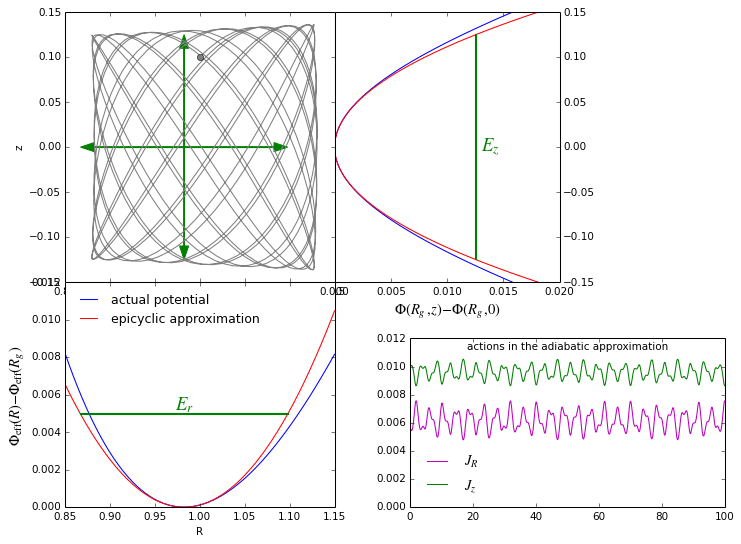

In [6]:
pot = agama.Potential(type='MiyamotoNagai', scaleRadius=1, scaleHeight=0.2)
ic = numpy.array([1., 0, 0.1, 0.1, 0.5, 0.1])
tim,orb = agama.orbit(potential=pot, ic=ic, time=100, trajsize=1001)
R   = (orb[:,0]**2+orb[:,1]**2)**0.5
z   =  orb[:,2]
phi = numpy.unwrap(numpy.arctan2(orb[:,1], orb[:,0]))

Lz = ic[0] * ic[4] - ic[1] * ic[3]
Rg = pot.Rcirc(L=Lz)  # guiding radius
Eg = pot.potential(Rg,0,0) + 0.5 * (Lz/Rg)**2  # effective potential at R=Rg
E  = pot.potential(ic[0:3]) + 0.5 * sum(ic[3:6]**2)
# acceleration (-dPhi / dxi) and its derivative (-d2Phi / dxi dxj)
acc, der = pot.eval([Rg,0,0], acc=True, der=True)
# epicyclic frequencies at R=Rg
kappa = (-der[0] - 3/Rg * acc[0])**0.5
nu    = (-der[2])**0.5
Omega = (-acc[0]/Rg)**0.5
Ez = pot.potential(numpy.column_stack((Rg+tim*0, tim*0, orb[:,2]))) - pot.potential(Rg,0,0) + 0.5*orb[:,5]**2
Er = E - Eg - Ez

plt.figure(figsize=(10,7.5))
ax1 = plt.axes([0.10, 0.50, 0.36, 0.48], aspect='equal')
ax2 = plt.axes([0.10, 0.10, 0.36, 0.40], sharex=ax1)
ax3 = plt.axes([0.46, 0.50, 0.30, 0.48], sharey=ax1)
ax4 = plt.axes([0.56, 0.10, 0.42, 0.30])
ax1.plot(R, z, color='gray')
ax1.plot(ic[0], ic[2], 'o', color='gray')
ax1.set_xlim( 0.85, 1.15)
ax1.set_ylim(-0.15, 0.15)
ax1.set_ylabel('z')
ax2.set_xlabel('R')
ax2.set_ylabel(r'$\Phi_{\rm eff}(R) - \Phi_{\rm eff}(R_g)$', fontsize=14)
ax3.set_xlabel(r'$\Phi(R_g,z) - \Phi(R_g,0)$', fontsize=14)
ax3.yaxis.tick_right()
# effective potential Phi_eff(R,z=0) and its quadratic epicyclic approximation
RR = numpy.linspace(0.85, 1.15, 61)
ax2.plot(RR, pot.potential(numpy.column_stack((RR, RR*0, RR*0))) + 0.5 * (Lz/RR)**2 - Eg,
    color='b', label='actual potential')
ax2.plot(RR, 0.5 * kappa**2 * (RR-Rg)**2, color='r', label='epicyclic approximation')
ax2.legend(loc='upper left', frameon=False)
# vertical potential Phi(Rg,z) and its quadratic epicyclic approximation
zz = numpy.linspace(-0.15, 0.15, 61)
ax3.plot(pot.potential(numpy.column_stack((Rg+zz*0, zz*0, zz))) - pot.potential(Rg,0,0), zz,
    color='b', label='actual potential')
ax3.plot(0.5 * nu**2 * zz**2, zz, color='r', label='epicyclic approximation')

# extent of oscillations from the epicyclic approx. at the fiducial (initial) point
deltaR = (2*Er[0])**0.5 / kappa
ax1.arrow(Rg, 0, -deltaR, 0, color='g', head_width=0.01, length_includes_head=True)
ax1.arrow(Rg, 0, +deltaR, 0, color='g', head_width=0.01, length_includes_head=True)
ax2.plot([Rg-deltaR, Rg+deltaR], [Er[0], Er[0]], color='g', lw=2)
ax2.text(Rg, Er[0], r'$E_r$', ha='center', va='bottom', color='g', fontsize=18)
deltaz = (2*Ez[0])**0.5 / nu
ax1.arrow(Rg, 0, 0, -deltaz, color='g', head_width=0.01, length_includes_head=True)
ax1.arrow(Rg, 0, 0, +deltaz, color='g', head_width=0.01, length_includes_head=True)
ax3.plot([Ez[0], Ez[0]], [-deltaz, deltaz], color='g', lw=2)
ax3.text(Ez[0]+0.0005, 0, r'$E_z$', ha='left', va='center', color='g', fontsize=18)

# variation of approximate actions along the orbit
ax4.plot(tim, Er/kappa, label='$J_R$', color='m')
ax4.plot(tim, Ez/nu,    label='$J_z$', color='g')
ax4.legend(loc='lower left', frameon=False, fontsize=14)
ax4.set_xlim(0, tim[-1])
ax4.set_ylim(0, 0.012)
ax4.text(0.5, 0.98, 'actions in the adiabatic approximation', transform=ax4.transAxes, ha='center', va='top')
print('R_g=%.3g, eccentricity=%.2g, sin(inclination)=%.2g, kappa=%.3g, nu=%.3g, Omega=%.3g' %
    (Rg, deltaR/Rg, deltaz/Rg, kappa, nu, Omega))

As clear from the above illustration, the epicyclic approximation is okayish but not particularly good even for moderately eccentric and inclined orbits – the actions vary along the orbit by $\mathcal O(\text{max}(e,\sin i))$.<br>
One can improve upon it by continuing to assume that the motion is separable in $R$ and $z$, but using the 1d cross-sections of the actual potential $\Phi_\text{eff}(R,z=0)$ and $\Phi(R,z)-\Phi(R,z=0)$ instead of their epicyclic (quadratic) approximations. This is known as the *adiabatic approximation*, and actions are given by 1d integrals (hence more expensive). However, for the same computational cost, one can do much better by using the Stäckel approximation. It is based on the fact that in a special class of potentials, action–angle transformations can be performed exactly.

#### Actions in axisymmetric Stäckel potentials

In this section we use *prolate spheroidal* coordinates $\{u,v\}$ when dealing with *oblate axisymmetric* potentials. These are related to the cylindrical coordinates as follows:
$R = \Delta\, \sinh u\,\sin v, \; z = \Delta\, \cosh u\,\cos v,\;$ where $\Delta$ is the focal distance.<br>
At small/large radii, the coordinate lines are close to cylindrical/spherical alignment, respectively; $u$ plays the role of radius ($R$ or $r$), and $v\in [0..\pi]$ is the analogue of the polar angle $\vartheta$ at large radii, or is related to $z$ at small radii.

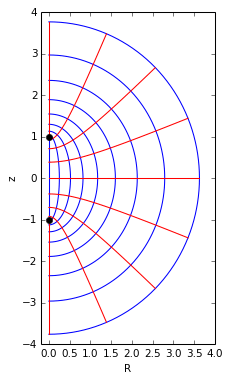

In [7]:
def convertUVtoRZ(u, v, Delta):
    return Delta * numpy.sinh(u) * numpy.sin(v), Delta * numpy.cosh(u) * numpy.cos(v)

def convertRZtoUV(R, z, Delta):
    a = R**2 + z**2 + Delta**2
    b = R**2 + z**2 - Delta**2
    c = (b**2 + 4*R**2*Delta**2)**0.5
    u = numpy.arccosh((0.5 * (a+c))**0.5 / Delta)
    v = numpy.arccos ((0.5 * (a-c))**0.5 / Delta)
    v[z<0] = numpy.pi - v[z<0]
    return u, v

def showCoords(ax, Delta, coloru='b', colorv='r'):
    ugrid = numpy.linspace(0, 2, 81)
    vgrid = numpy.linspace(0, 1, 81) * numpy.pi
    for u in ugrid[::10]:
        R, z = convertUVtoRZ(u, vgrid, Delta)
        ax.plot(R, z, color=coloru)
    for v in vgrid[::10]:
        R, z = convertUVtoRZ(ugrid, v, Delta)
        ax.plot(R, z, color=colorv)
    ax.plot([0,0], [-Delta,Delta], 'ko')
    ax.set_xlim(-0.2, 4)
    ax.set_ylim(-4,4)
    ax.set_xlabel('R')
    ax.set_ylabel('z')

ax = plt.figure(figsize=(3,6)).add_subplot(1,1,1,aspect='equal')
showCoords(ax, 1.0)

A potential $\Phi(R,z)$ is of a Stäckel form if it can be represented in spheroidal coordinates as
$\displaystyle \Phi(u,v) = \frac{U(u) - V(v)}{\sinh^2 u + \sin^2 v}$, where $U(u)$ and $V(v)$ are two arbitrary 1d functions.<br>
A well-known example of such potential is the Perfect Ellipsoid ([de Zeeuw 1985](http://adsabs.harvard.edu/abs/1985MNRAS.216..273D)). It corresponds to an ellipsoidally stratified density profile $\displaystyle \rho(R,z) = \frac{M}{\pi^2 a^3 q} \left[ 1 + \frac{R^2 + (z/q)^2}{a^2} \right]^{-2}$ with axis ratio $q=z/x$.

The motion is separable in $u, v$, and the actions $J_u$, $J_v$ and all phase angles are computed by 1d integrals; they are associated with the radial and vertical action, respectively. The azimuthal action $J_\varphi$ is identical to $L_z$, as before.<br>
Note that, despite separability, motion is not simply periodic in any single coordinate ($u, v, \varphi$), although $u$ gets close. Rather, each coordinate completes the full circle (from $u_\text{min}$ to $u_\text{max}$ and back to $u_\text{min}$, or from 0 to $2\pi$ for $v$ and $\varphi$) only *on average* once per corresponding period (marked by black dots in each panel).

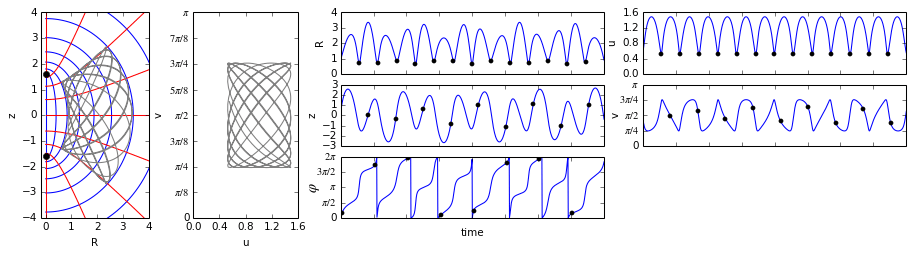

In [8]:
a = 2.0  # major axis of the profile
q = 0.6  # axis ratio z/R
Delta = a * (1-q**2)**0.5  # focal distance of the corresponding prolate spheroidal coordinate system
pot = agama.Potential(type='PerfectEllipsoid', scaleRadius=a, axisRatioZ=q)
ic = numpy.array([0.95, 0, 0.3, 0.1, 0.3, 0.45])
tim,orb = agama.orbit(potential=pot, ic=ic, time=400, trajsize=1001)
act,ang = agama.actions(pot, orb, Delta, angles=True, frequencies=False)
ang = numpy.unwrap(ang, axis=0)
R = (orb[:,0]**2 + orb[:,1]**2)**0.5
z =  orb[:,2]
phi = numpy.arctan2(orb[:,1], orb[:,0]) % (2*numpy.pi)
u, v = convertRZtoUV(R, z, Delta)
fig = plt.figure(figsize=(12, 3.2))
ax1 = fig.add_subplot(3,6,(1,13), aspect='equal')
ax2 = fig.add_subplot(3,6,(2,14), aspect='equal')
ax3 = fig.add_subplot(3,6,(3,4))
ax4 = fig.add_subplot(3,6,(9,10))
ax5 = fig.add_subplot(3,6,(15,16))
ax6 = fig.add_subplot(3,6,(5,6))
ax7 = fig.add_subplot(3,6,(11,12))
showCoords(ax1, Delta)
ax1.plot(R, z, c='gray')
ax2.plot(u, v, c='gray')
ax3.plot(tim, R, c='b')
ax4.plot(tim, z, c='b')
ax5.plot(tim, phi, c='b')
ax6.plot(tim, u, c='b')
ax7.plot(tim, v, c='b')
# in each panel, plot points where the corresponding (unwrapped) phase angle is a multiple of 2pi
t0u = numpy.interp(numpy.linspace(0, 30*numpy.pi, 16), ang[:,0], tim, left=numpy.nan, right=numpy.nan)  # R,u
t0v = numpy.interp(numpy.linspace(0, 30*numpy.pi, 16), ang[:,1], tim, left=numpy.nan, right=numpy.nan)  # z,v
t0a = numpy.interp(numpy.linspace(0, 30*numpy.pi, 16), ang[:,2], tim, left=numpy.nan, right=numpy.nan)  # phi
ax3.plot(t0u, numpy.interp(t0u, tim, R),  'ko', ms=4)
ax4.plot(t0v, numpy.interp(t0v, tim, z),  'ko', ms=4)
ax5.plot(t0a, numpy.interp(t0a, tim, phi),'ko', ms=4)
ax6.plot(t0u, numpy.interp(t0u, tim, u),  'ko', ms=4)
ax7.plot(t0v, numpy.interp(t0v, tim, v),  'ko', ms=4)
# beautification...
ax2.set_xlim(0, 1.6)
ax3.set_ylim(0, 4)
ax4.set_ylim(-3, 3)
ax5.set_ylim(0, numpy.pi*2)
ax6.set_ylim(0, 1.6)
ax7.set_ylim(0, numpy.pi)
for ax in (ax3,ax4,ax5,ax6,ax7): ax.set_xlim(0, tim[-1]); ax.set_xticklabels([])
ax1.set_xticks(numpy.linspace(0, 4, 5))
ax2.set_xticks(numpy.linspace(0, 1.6, 5))
ax2.set_yticks(numpy.linspace(0, numpy.pi, 9))
ax2.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$', r'$5\pi/8$', r'$3\pi/4$', r'$7\pi/8$', r'$\pi$'])
ax2.set_xlabel('u')
ax2.set_ylabel('v')
ax3.set_yticks(ax1.get_xticks())
ax6.set_yticks(ax2.get_xticks())
ax5.set_yticks(numpy.linspace(0, numpy.pi*2, 5))
ax7.set_yticks(numpy.linspace(0, numpy.pi, 5))
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax6.set_xticklabels([])
ax5.set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
ax7.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
ax3.set_ylabel('R')
ax4.set_ylabel('z')
ax5.set_ylabel(r'$\varphi$', fontsize=14, labelpad=-6)
ax6.set_ylabel('u')
ax7.set_ylabel('v', labelpad=-2)
ax5.set_xlabel('time')
plt.tight_layout(pad=0)

#### Stäckel fudge

The above method is strictly valid only for a restricted class of Stäckel potentials; however, its generalization works reasonably well for most realistic galactic potentials. Namely, we *pretend* that the potential is of a Stäckel form, and compute the actions using the same expressions as above (integrating the canonical momenta $p_u$, $p_v$ along lines of constant $v$ and $u$, respectively). In this approach, introduced by [Binney(2012)](http://adsabs.harvard.edu/abs/2012MNRAS.426.1324B), we use the actual potential in this integration; a variant proposed by [Sanders(2012)](http://adsabs.harvard.edu/abs/2012MNRAS.426..128S) first constructs a best-fit Stäckel approximation to the actual potential in the spatial region spanned by the orbit, which is more expensive but slightly more accurate.

The method works fairly well, because most orbits in realistic potentials span regions in the $R,z$ plane that align quite closely with prolate spheroidal coordinates (in any case, much better than with either cylindrical or spherical coordinates, as illustrated below).

rms scatter of actions [Jr, Jz]:
spherical:   [ 0.06665603  0.0412977 ]
cylindrical: [ 0.0818927   0.05760604]
spheroidal:  [ 0.00657582  0.00849515]


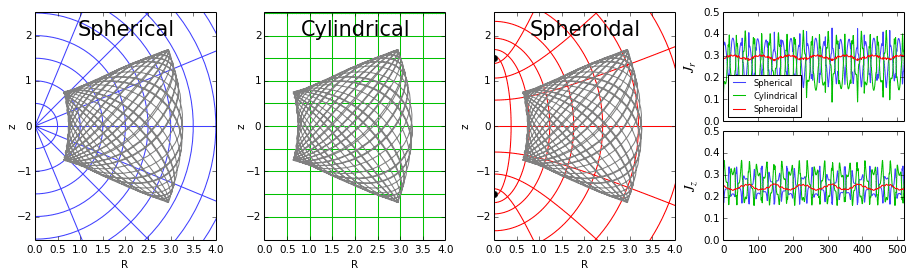

In [9]:
pot = agama.Potential(type='Disk', scaleRadius=1, scaleHeight=0.3)
ic = numpy.array([1.0, 0, 0.2, 0.4, 0.5, 0.6])
tim,orb = agama.orbit(potential=pot, ic=ic, time=20*pot.Tcirc(ic), trajsize=1001)
R = (orb[:,0]**2 + orb[:,1]**2)**0.5
z =  orb[:,2]
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(2,4,(1,5), aspect='equal')
ax2 = fig.add_subplot(2,4,(2,6), aspect='equal', sharex=ax1)
ax3 = fig.add_subplot(2,4,(3,7), aspect='equal', sharex=ax1)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,8, sharey=ax4)
Delta = 1.5
actSph = agama.actions(pot, orb, fd=1e-2)  # spherical: focal distance (almost) zero
actCyl = agama.actions(pot, orb, fd=1e+2)  # cylindrical: focal distance (almost) infinity
actStk = agama.actions(pot, orb, fd=Delta) # prolate spheroidal with optimal choice of focal distance
print('rms scatter of actions [Jr, Jz]:')
print('spherical:   %s' % numpy.std(actSph[:,0:2], axis=0))
print('cylindrical: %s' % numpy.std(actCyl[:,0:2], axis=0))
print('spheroidal:  %s' % numpy.std(actStk[:,0:2], axis=0))
c1='#4040FF'
c2='#00C000'
c3='#FF0000'
# draw spherical, cylindrical and prolate spheroidal coords in the three panels
theta = numpy.linspace(0, numpy.pi)
for r in numpy.linspace(0, 5, 11):
    ax1.plot(r*numpy.sin(theta), r*numpy.cos(theta), color=c1)
for theta in numpy.linspace(0, numpy.pi, 9):
    ax1.plot([0, 5*numpy.sin(theta)], [0, 5*numpy.cos(theta)], color=c1)
for x in numpy.linspace(-2, 3.5, 12):
    ax2.plot([0, 4], [x, x], color=c2)
    ax2.plot([x, x], [-3,3], color=c2)
showCoords(ax3, Delta, coloru=c3, colorv=c3)
for ax in ax1,ax2,ax3:
    ax.plot(R, z, color='gray')
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('R')
ax1.text(2, 2, 'Spherical',   ha='center', fontsize=20)
ax2.text(2, 2, 'Cylindrical', ha='center', fontsize=20)
ax3.text(2, 2, 'Spheroidal',  ha='center', fontsize=20)
ax4.plot(tim, actSph[:,0], color=c1, label='Spherical')
ax4.plot(tim, actCyl[:,0], color=c2, label='Cylindrical')
ax4.plot(tim, actStk[:,0], color=c3, label='Spheroidal')
ax5.plot(tim, actSph[:,1], color=c1)
ax5.plot(tim, actCyl[:,1], color=c2)
ax5.plot(tim, actStk[:,1], color=c3)
ax4.set_xticklabels([])
ax4.legend(loc='lower left', fontsize=8, frameon=True)
ax1.set_xlim(0, 4)
ax1.set_ylabel('z', labelpad=0)
ax2.set_ylabel('z', labelpad=0)
ax4.set_ylabel('$J_r$', fontsize=14)
ax5.set_ylabel('$J_z$', fontsize=14)
ax4.set_xlim(0, tim[-1])
ax5.set_xlim(0, tim[-1])
ax4.set_ylim(0, 0.5)
plt.tight_layout(pad=0)

The right panels show the time variation of actions computed in three coordinate systems: spherical (focal distance $\Delta=0$), cylindrical ($\Delta=\infty$), and prolate spheroidal with a fiducial choice of $\Delta$.
Of course, real actions should be conserved along the orbit (in a static potential, anyway), and the large scatter in the first two cases demonstrates them to be poor approximations, whereas the third case is much better.

In fact, the only adjustable parameter in the Stäckel fudge is $\Delta$, and its accuracy depends stongly on its choice. Other codes such as `galpy` use a fixed value for the entire galaxy, or compute $\Delta$ using the potential derivatives (eqs.8–9 in [Sanders 2012](http://adsabs.harvard.edu/abs/2012MNRAS.426..128S)). Both these choices are less accurate than the one used in Agama, namely, interpolation from a pre-computed grid of $\Delta(E,L_z)$ that is fitted to thin (shell) orbits with $J_r=0$. 
This grid is initialized by creating an instance of `ActionFinder` for the given potential, rather than calling the `actions` function (with needs a manually specified focal distance).

The axisymmetric action finder takes $\mathcal O(1)$ second to create, and provides a nearly optimal choice of $\Delta$ for all orbits in the given potential (note that there is no single value for the entire galaxy!). A variant of the method creates a 3d interpolation table for $J_{r,z}$ as functions of three integrals of motion (two classical and the approximate third integral, which itself depends on $\Delta$). In this variant, actions (but not angles) are computed ~10x faster, but are more approximate; the tradeoff may or may not be worthwhile (in this example, the accuracy is similar for both interpolated and non-interpolated variants).

In [10]:
af_default = agama.ActionFinder(pot)
af_interp  = agama.ActionFinder(pot, interp=True)
print('rms scatter of actions: standard fudge = %s, interpolated = %s' % (
    numpy.std(af_default(orb)[:,0:2], axis=0),
    numpy.std(af_interp (orb)[:,0:2], axis=0)))

rms scatter of actions: standard fudge = [ 0.0066847   0.00850447], interpolated = [ 0.00683252  0.00763676]


#### Action computation using generating functions

The Stäckel fudge is the method of choice for most applications, but its accuracy cannot be improved beyond a certain limit achieved at the optimal choice of focal distance. There is an entirely different class of methods that are *convergent*, i.e., can reach in principle arbitrarily small error at the expense of increasing the computational cost. They are based on the concept of *canonical transformations* of Hamiltonian systems, described by *generating functions*.

Recall that a canonical transformation is a mapping between two sets of 6d phase-space coordinates. Namely, we use the action-angle variables in some auxiliary *toy* potential $\{\boldsymbol \theta^\text{t}, \boldsymbol J^\text{t}\}$ and in the *actual* potential $\{\boldsymbol \theta^\text{a}, \boldsymbol J^\text{a}\}$. 
The toy potential can be chosen such that the transformation between position/velocity and action/angle variables is analytic (e.g., Isochrone or harmonic potentials; the former suitable for tube orbits, the latter for boxes).
It makes sense to choose this toy potential to resemble the actual one as much as possible, but of course a spherical Isochrone would not match the non-spherical component of the actual potential, nor can it describe its radial profile in detail. Thus the *toy* actions computed along a numerically integrated orbit would not be constant, and making them constant is the goal of the canonical transformation described by the generating function  written in terms of Fourier series: $\displaystyle S(\boldsymbol \theta^\text{t}, \boldsymbol J^\text{a}) = \boldsymbol \theta^\text{t} \cdot \boldsymbol J^\text{a} + 2\sum_{\boldsymbol n} S_{\boldsymbol n}(\boldsymbol J^\text{a})\, \sin(\boldsymbol n \cdot \boldsymbol \theta^\text{t})$. Here the summation index $\boldsymbol n$ is a triplet of integer numbers, and by increasing the number of terms in this sum, we can approximate the actions $\boldsymbol J^\text{t}$ to any desired accuracy. Namely, by adjusting the Fourier coefficients $S_{\boldsymbol n}$, we aim to minimize the scatter in $\boldsymbol J^\text{t}$ computed over a grid of toy angles $\boldsymbol \theta^\text{t}_{i=1..N_\text{points}}$, using the toy potential for points along the orbit. This is a straightforward linear least-square problem, described in detail in [Sanders & Binney 2014](http://adsabs.harvard.edu/abs/2014MNRAS.441.3284S).<br>
An earlier variant of the method ([Fox 2014](http://adsabs.harvard.edu/abs/2014arXiv1407.1688F), [Bovy 2014](http://adsabs.harvard.edu/abs/2014ApJ...795...95B)) used a simpler expression for computing the real actions by averaging the toy actions over toy angles: $\boldsymbol J^\text{a} \approx \frac{1}{(2\pi)^3} \iiint_0^{2\pi} \text{d}\boldsymbol\theta^\text{t}\, \boldsymbol J^\text{t}$. This averaging is non-trivial because the sampling of toy angle space is non-uniform, and in general produces less accurate values of actions (see [Sanders & Binney 2016](http://adsabs.harvard.edu/abs/2016MNRAS.457.2107S) for a comparison).

The generating function approach is currently not available in Agama (although planned for inclusion in a future version), but the example below shows a simplified Python implementation of both its variants (least-square fitting and simple averaging).
It is considerably more expensive than Stäckel fudge because of the need to integrate the orbit for a few dozen periods; however, it is also much more accurate, at least for normal (non-resonant) orbits.

Actions and their rms scatter:
Staeckel:  Jr = 0.221868 +- 0.022738,  Jz = 0.133387 +- 0.026044
O2GF:      Jr = 0.217569 +- 0.006027,  Jz = 0.138753 +- 0.003607
AvGF:      Jr = 0.208759,              Jz = 0.148024


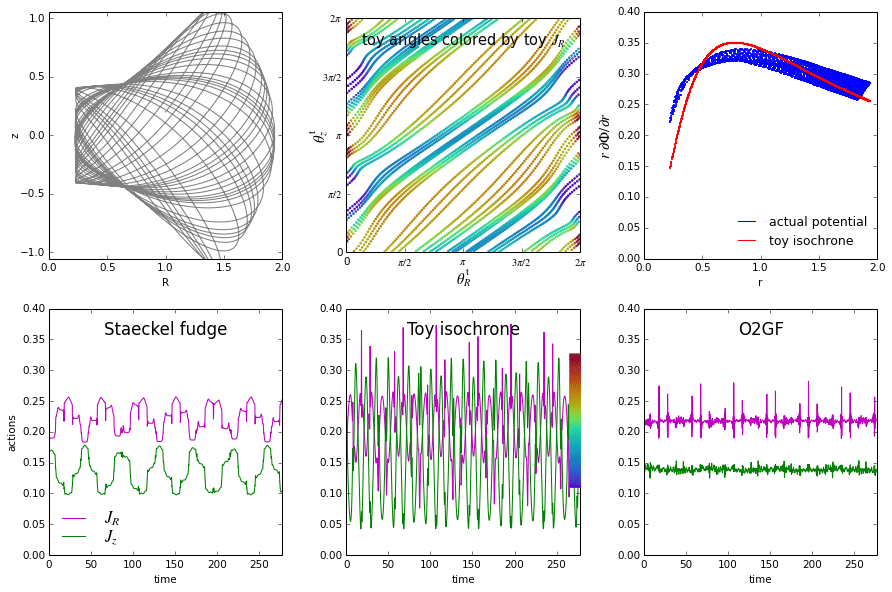

In [11]:
def runGenFunc(pot, ic, nperiods=20):
    tim,orb = agama.orbit(potential=pot, ic=ic, time=nperiods*pot.Tcirc(ic), trajsize=nperiods*200+1)
    R = (orb[:,0]**2 + orb[:,1]**2)**0.5
    z =  orb[:,2]
    r = (R**2 + z**2)**0.5

    # First step: choose suitable parameters for the toy Isochrone potential,
    # by approximating the circular-velocity profile of the actual potential in the least-square sense:
    # vcirc2 = r * dPhi/dr for each point on the orbit
    def fitIsochrone(params):
        M, b = numpy.exp(params)  # by using exp-scaling, avoid complications of a constrained fitting problem
        potToy = agama.Potential(type='Isochrone', mass=M, scaleRadius=b)
        vcirc2Toy = numpy.sum(-potToy.force(orb[:,0:3]) * orb[:,0:3], axis=1)
        return (vcirc2-vcirc2Toy)
    vcirc2 = numpy.sum(-pot.force(orb[:,0:3]) * orb[:,0:3], axis=1)
    params = scipy.optimize.leastsq(fitIsochrone, [1.,1.])[0]
    M, b = numpy.exp(params)
    potToy = agama.Potential(type='Isochrone', mass=M, scaleRadius=b)

    # Second step: compute the toy actions and angles in the fiducial Isochrone potential
    actToy, angToy = agama.ActionFinder(potToy)(orb, angles=True, frequencies=False)

    # Third step, variant 1: a simplified implementation of the Sanders & Binney (2014) O2GF algorithm
    def actionsOGF(actToy, angToy, nmax=8):
        triplets = []
        for nr in range(-nmax, nmax+1):
            for nz in range(0, nmax+1, 2):  # only even indices for nz due to z-reflection symmetry of the potential
                nphi = 0  # in axisymmetric systems
                if (nr>0 or nz>0 or nphi>0) and nr**2 + nz**2 + nphi**2 <= nmax**2:
                    triplets.append( (nr,nz,nphi) )
        triplets = numpy.vstack(triplets)  # shape: (ntriplets,3)
        ntriplets = len(triplets)
        npoints = len(actToy)
        A = numpy.zeros((ntriplets+3, ntriplets+3))  # eq.14 in SB14
        b = numpy.zeros( ntriplets+3 )  # eq.13
        c = 2 * triplets[:,None,:] * numpy.cos(numpy.einsum('nd,id->ni', triplets, angToy))[:,:,None]  # shape: (ntriplets, npoints, 3); eq.12
        A[0,0] = A[1,1] = A[2,2] = npoints
        A[3:, 0:3] = numpy.sum(c, axis=1)
        A[0:3,3: ] = A[3:,0:3].T
        A[3:, 3: ] = numpy.einsum('nid,mid->nm', c, c)
        b[:3]  = numpy.sum(actToy, axis=0)
        b[3:]  = numpy.einsum('nid,id->n', c, actToy)
        result = numpy.linalg.solve(A, b)  # shape: (ntriplets+3), first 3 elements are actions, remaining elements are S_n
        actOGF = result[0:3]  # overall actions
        actOGFi= actToy - numpy.einsum('nid,n->id', c, result[3:])  # approximate actions at each point on the orbit
        return actOGF, actOGFi

    actOGF, actOGFi = actionsOGF(actToy, angToy)

    # Third step, variant 2, in which the toy actions are averaged over toy angles.
    # first need to unwrap the angles to make them monotonic, then use the trapezoid rule to integrate over angles.
    angToyUnwrap = numpy.unwrap(angToy, axis=0)
    actAGF = numpy.sum(0.5 * (actToy[1:] + actToy[:-1]) * numpy.diff(angToyUnwrap, axis=0), axis=0) / (angToyUnwrap[-1]-angToyUnwrap[0])

    # for comparison, use the actions computed with the Stäckel fudge
    actStk, angStk = agama.ActionFinder(pot)(orb, angles=True, frequencies=False)

    print("Actions and their rms scatter:")
    print("Staeckel:  Jr = %.6f +- %.6f,  Jz = %.6f +- %.6f" %
        (numpy.mean(actStk[:,0]), numpy.std(actStk[:,0]), numpy.mean(actStk[:,1]), numpy.std(actStk[:,1])))
    print("O2GF:      Jr = %.6f +- %.6f,  Jz = %.6f +- %.6f" %
        (actOGF[0], numpy.std(actOGFi[:,0]), actOGF[1], numpy.std(actOGFi[:,1])))
    print("AvGF:      Jr = %.6f,              Jz = %.6f" % tuple(actAGF[0:2]))

    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(2,3,1, aspect='equal')
    ax2 = fig.add_subplot(2,3,2, aspect='equal')
    ax3 = fig.add_subplot(2,3,3, sharex=ax1)
    ax4 = fig.add_subplot(2,3,4)
    ax5 = fig.add_subplot(2,3,5, sharex=ax4, sharey=ax4)
    ax6 = fig.add_subplot(2,3,6, sharex=ax4, sharey=ax4)
    ax1.plot(R, z, color='gray')
    ax1.set_xlim(0, 2.0)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_xlabel('R')
    ax1.set_ylabel('z', labelpad=0)
    # plot the 2d space of toy angles, colored by one of toy actions (radial)
    toyJrmin, toyJrmax = actOGF[0]*0.5, actOGF[0]*1.5
    ax2.scatter(angToy[:,0], angToy[:,1], marker='o', s=6, lw=0, c=actToy[:,0], cmap='mist', vmin=toyJrmin, vmax=toyJrmax)
    ax2.set_xlim(0, 2*numpy.pi)
    ax2.set_ylim(0, 2*numpy.pi)
    ax2.set_xticks(numpy.linspace(0, 2*numpy.pi, 5))
    ax2.set_yticks(numpy.linspace(0, 2*numpy.pi, 5))
    ax2.set_xlabel(r'$\theta_R^{\rm t}$', fontsize=14, labelpad=0)
    ax2.set_ylabel(r'$\theta_z^{\rm t}$', fontsize=14, labelpad=-8)
    ax2.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax2.set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax2.text(0.5, 0.95, 'toy angles colored by toy $J_R$', ha='center', va='top', transform=ax2.transAxes, fontsize=14)
    ax3.plot(r, vcirc2, 'bo', ms=2, mew=0)
    ax3.plot(r, numpy.sum(-potToy.force(orb[:,0:3]) * orb[:,0:3], axis=1), 'ro', ms=2, mew=0)
    ax3.plot(numpy.nan, numpy.nan, color='b', label='actual potential')
    ax3.plot(numpy.nan, numpy.nan, color='r', label='toy isochrone')
    ax3.set_xlabel('r')
    ax3.set_ylabel(r'$r\,\partial\Phi/\partial r$', fontsize=14)
    ax3.legend(loc='lower right', frameon=False)
    ax3.set_ylim(0, 0.4)
    ax4.plot(tim, actStk [:,0], color='m', label='$J_R$')
    ax4.plot(tim, actStk [:,1], color='g', label='$J_z$')
    ax5.plot(tim, actToy [:,0], color='m')
    ax5.plot(tim, actToy [:,1], color='g')
    ax5.imshow(numpy.linspace(0, 1, 128).reshape(-1,1), extent=[tim[-1]*0.95, tim[-1], toyJrmin, toyJrmax],
               aspect='auto', interpolation='nearest', origin='lower', cmap='mist', vmin=0, vmax=1, zorder=10)
    ax6.plot(tim, actOGFi[:,0], color='m')
    ax6.plot(tim, actOGFi[:,1], color='g')
    ax4.set_xlim(0, tim[-1])
    ax4.set_ylim(0, 0.4)
    ax4.set_ylabel('actions')
    for ax in (ax4,ax5,ax6): ax.set_xlabel('time')
    ax4.legend(loc='lower left', frameon=False, fontsize=16, labelspacing=0, borderpad=0)
    ax4.text(0.5, 0.95, 'Staeckel fudge', fontsize=16, ha='center', va='top', transform=ax4.transAxes)
    ax5.text(0.5, 0.95, 'Toy isochrone',  fontsize=16, ha='center', va='top', transform=ax5.transAxes)
    ax6.text(0.5, 0.95, 'O2GF', fontsize=16, ha='center', va='top', transform=ax6.transAxes)
    plt.tight_layout()
    return actOGF

pot = agama.Potential(type='Spheroid', axisRatioZ=0.3)  # strongly flattened Hernquist potential
actOGF = runGenFunc(pot, ic=numpy.array([1.0, 0, 0.2, 0.4, 0.2, 0.5]))

In this case, the Stäckel approximation is not as good as before, since the orbit shape is not so closely aligned with spheroidal coordinates for any choice of focal distance. 
The toy isochrone by itself fares much worse, with the toy actions $J^\text{t}$ having a large scatter and toy angles being somewhat wonky, rather than moving along straight lines as functions of time (top central panel). However, it is clear from that plot that the variation of toy actions (shown by color for $J^\text{t}_R$) across toy angles is rather smooth, and can be represented by a 2d Fourier expansion in $\theta^\text{t}_R, \theta^\text{t}_z$ with a moderate number of terms (a few dozen combinations of integer pairs $n_R,n_z$). This is exactly what the generating function does; the least-square fit to $J^\text{t}_{R,z} \approx J^\text{a}_{R,z} + 2\sum_{\boldsymbol n} \boldsymbol n\,S_\boldsymbol n\,\cos(\boldsymbol n \cdot \boldsymbol \theta^\text{t})$ recovers both the "offsets" $J^\text{a}_{R,z}$ (which are the actual values that we are interested in) and the Fourier coefficients $S_\boldsymbol n$, and the residuals in this approximation are much smaller (the scatter is illustrated in the bottom right panel). A simpler averaging procedure used in Galpy produces a less accurate estimate of the mean $\boldsymbol J^\text{a}$.

So, is the generating function approach the ultimate solution? Yes and no..<br>
The problem arises when the orbit is a resonant one; the simplest and most common example is the vertical 2:1 resonance, shown below. In this case both Stäckel and O2GF methods produce actions that vary dramatically along the orbit, i.e. are not accurate at all. The reason is that the orbit does not cover a symmetric region in the $R,z$ plane, and likewise the toy angles do not cover the entire cube. The generating function approach can in principle be extended to handle these cases, by first employing an additional *point transformation* for coordinates, but this would require that the orbital class be identified and a suitable transformation designed for each specific situation; this has not been used in practice.

Actions and their rms scatter:
Staeckel:  Jr = 0.259957 +- 0.028423,  Jz = 0.078049 +- 0.029198
O2GF:      Jr = 0.279936 +- 0.029635,  Jz = 0.055835 +- 0.036016
AvGF:      Jr = 0.256552,              Jz = 0.077116


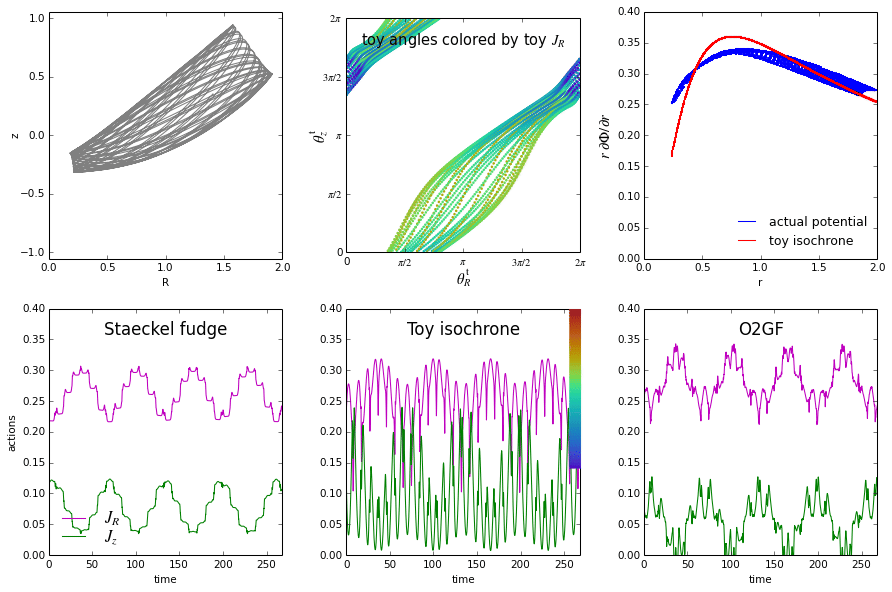

In [12]:
_ = runGenFunc(pot, ic=numpy.array([1.0, 0, 0.4, 0.4, 0.2, 0.4]))

### Transforming from action/angles to position/velocity

All of the above discussion was revolving around computing actions (and possibly angles) from position/velocity variables, which is indeed the more common usage scenario. What about the inverse transformation (called "Action mapping" in Agama)?

For the `Isochrone` potential this transformation is also analytic, and for any spherical potential it can be performed by a straightforward 1d root-finding (determining the radius $r$ corresponding to the given radial phase angle $\theta_r$; the other two angles are then treated analytically). In principle, this approach could be used with any axisymmetric potential under the Stäckel approximation, but as discussed earlier, the motion is not simply periodic in any coordinate, so one would need to determine both $R$ and $z$ from $\theta_R,\theta_z$ simultaneously. This has not been used in practice, and instead one employs the *torus construction* method based on canonical transformations, but in reverse direction ([McGill & Binney 1990](http://adsabs.harvard.edu/abs/1990MNRAS.244..634M), [Binney & Kumar 1993](http://adsabs.harvard.edu/abs/1993MNRAS.261..584B), [Binney & McMillan 2016](http://adsabs.harvard.edu/abs/2016MNRAS.456.1982B)). The latter paper introduced the `TorusMapper` code, which has been incorporated into Agama with some modifications (most notably, a newer angle mapping method from [Laakso & Kaasalainen 2013](http://adsabs.harvard.edu/abs/2013PhyD..243...14L)).

The general idea behind torus construction is similar to the O2GF action finder: starting from a fiducial toy potential in which the action/angle transformation can be performed analytically (e.g., `Isochrone`), design a canonical transformation from the *actual* action/angle variables $\{\boldsymbol \theta^\text{a}, \boldsymbol J^\text{a}\}$ to the *toy* ones $\{\boldsymbol \theta^\text{t}, \boldsymbol J^\text{t}\}$. The mapping from the toy actions/angles to $\{\boldsymbol q, \boldsymbol p\}$ is analytic, but another step (a point transformation) may be needed to finally get the position/velocity in the actual potential. This last step is triggered for thin orbits with $J_R \ll L$, which would otherwise need a prohibitively large number of Fourier terms in the generating function to map accurately. For all other orbits, $\{\boldsymbol q, \boldsymbol p\}$ coincide with $\{\boldsymbol x, \boldsymbol v\}$.<br>
As in the O2GF method, the coefficients $S_{\boldsymbol n}$ in the Fourier expansion of the generating function (and their derivatives $\partial S_{\boldsymbol n}/\partial \boldsymbol J$) are free parameters computed by minimizing the variance of the Hamiltonian $H(\boldsymbol q, \boldsymbol p) \equiv \Phi(\boldsymbol q_{(i)}) + \frac{1}{2}|\boldsymbol p_{(i)}|^2$ across a grid of regularly spaced toy angles $\boldsymbol \theta^\text{t}_{(i)}$ covering the entire torus. However, this procedure is more complicated in this reverse direction, because both steps in the mapping $\{\boldsymbol \theta^\text{t}, \boldsymbol J^\text{t}\} \to \{\boldsymbol q, \boldsymbol p\} \to H(\boldsymbol q, \boldsymbol p)$ are nonlinear, and the parameters of the toy potential (and possibly the point transformation) are also adjusted during the fit. In practice, this procedure may fail to converge (especially when the chosen triplet of actions corresponds to a resonant orbit, but sometimes in other cases as well).<br>
When the torus construction is successfull, it provides the full chain of transformations $\{\boldsymbol \theta^\text{a}, \boldsymbol J^\text{a}\} \to \{\boldsymbol \theta^\text{t}, \boldsymbol J^\text{t}\} \to \{\boldsymbol q, \boldsymbol p\} \to \{\boldsymbol x, \boldsymbol v\}$, whose parameters depend only on the given triplet of actions $\boldsymbol J^\text{a}$, but not on the angles $\boldsymbol \theta^\text{a}$. This means that one can now very efficiently compute the position and velocity for any choice of phase angles, effectively providing a way to move "fast-forward" along the orbit by an arbitrary time, without having to integrate the equations of motion numerically. Thus a torus specified by $\boldsymbol J^\text{a}$ is equivalent to an entire orbit with these actions, integrated for an infinitely long time. The caveat is, as before, that the procedure needs to be modified for resonantly trapped orbits, and although its feasibility has been demonstrated in some papers ([Kaasalainen & Binney 1994](http://adsabs.harvard.edu/abs/1994MNRAS.268.1033K),
[Binney 2016](http://adsabs.harvard.edu/abs/2016MNRAS.462.2792B)), this extension is not available in Agama's version of TorusMapper.

The `ActionMapper` class in Agama provides a unified interface to three underlying methods for mapping from action/angle to position/velocity variables: analytic map for the `Isochrone` potential, a more general method for any spherical potential, and the TorusMapper for any axisymmetric potential. The first two have already been illustrated earlier, so in the example below, we use the same flattened Hernquist potential as for the O2GF action finder. An instance of `ActionMapper` is a callable object that returns an array of $\{\boldsymbol x, \boldsymbol v\}$ for the input array of $\{\boldsymbol J,\boldsymbol \theta\}$ (one or more points). 
In the case of TorusMapper, each new triplet of actions provided as input invokes the construction of a corresponding torus (a non-negligible cost), which is then cached for subsequent use with any number of triplets of angles, whereas the other two methods don't care whether the given triplet of actions has been used before or not.

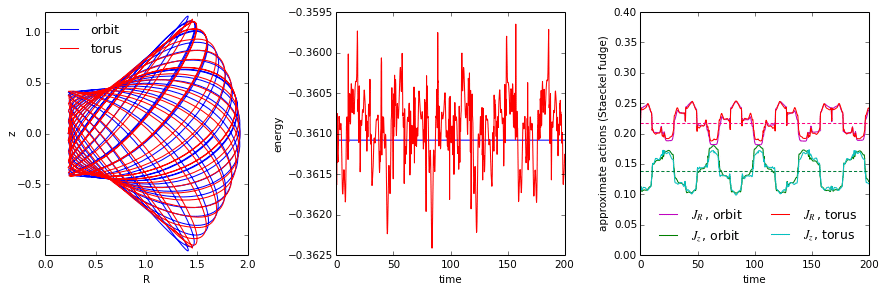

In [13]:
# construct an instance of action mapper for the given potential,
# which internally creates a new TorusMapper for each unique triplet of actions
# (here we use only one such triplet determined above by the O2GF method)
am = agama.ActionMapper(pot)
# retrieve the 6d phase-space coordinates for one choice of angles (zeros) and the orbital frequencies
act = actOGF
xv, Omega = am(numpy.hstack([act, 0, 0, 0]), frequencies=True)
# numerically integrate the orbit with the given initial conditions
tim,orb = agama.orbit(potential=pot, ic=xv, time=200, trajsize=1001)
# alternatively, compute the trajectory with the action mapper
# for a set of angles that linearly increase with time in proportion to orbital frequencies
angles = tim[:,None] * Omega
actions = numpy.tile(act, len(angles)).reshape(-1,3)  # repeat the triplet of actions
tor = am(numpy.hstack([actions, angles]))
# for comparison, compute actions using the Stäckel approximation for both the orbit and the torus;
# the error in this approximation is much larger than the difference between the two sets of points
af = agama.ActionFinder(pot)
act_orb = af(orb)
act_tor = af(tor)

ax1,ax2,ax3 = plt.subplots(1, 3, figsize=(12,4))[1]
# R,z cross-section of the numerically integrated orbit and its torus-mapped counterpart
ax1.plot((orb[:,0]**2 + orb[:,1]**2)**0.5, orb[:,2], color='b', label='orbit')
ax1.plot((tor[:,0]**2 + tor[:,1]**2)**0.5, tor[:,2], color='r', label='torus')
ax1.set_aspect('equal')
ax1.set_xlim(0, 2)
ax1.set_ylim(-1.2, 1.2)
ax1.set_xlabel('R')
ax1.set_ylabel('z', labelpad=0)
ax1.legend(loc='upper left', frameon=False)
# scatter in the total energy for the torus-mapped trajectory (a measure of its accuracy)
ax2.plot(tim, pot.potential(orb[:,0:3]) + 0.5 * numpy.sum(orb[:,3:6]**2, axis=1), color='b')
ax2.plot(tim, pot.potential(tor[:,0:3]) + 0.5 * numpy.sum(tor[:,3:6]**2, axis=1), color='r')
ax2.set_xlim(0, tim[-1])
ax2.set_xlabel('time')
ax2.set_ylabel('energy')
# evolution of actions computed with the Stäckel approximation
ax3.plot(tim, act_orb[:,0], color='m', label='$J_R$, orbit')
ax3.plot(tim, act_orb[:,1], color='g', label='$J_z$, orbit')
ax3.plot(tim, act_tor[:,0], color='r', label='$J_R$, torus')
ax3.plot(tim, act_tor[:,1], color='c', label='$J_z$, torus')
ax3.axhline(act[0], dashes=[3,2], color='#ff0080')  # input actions provided to TorusMapper
ax3.axhline(act[1], dashes=[3,2], color='#008040')
ax3.set_xlim(0, tim[-1])
ax3.set_xlabel('time')
ax3.set_ylim(0, 0.4)
ax3.set_ylabel('approximate actions (Staeckel fudge)')
ax3.legend(loc='lower right', ncol=2, frameon=False)
plt.tight_layout()
None

### Properties of action/angle variables

- Actions have a clear physical meaning (describe the extent of oscillations in each dimension)
- Angles most naturally describe the motion along the orbit (change linearly with time)
- Actions live in one quarter of the flat 3d space: $0 \le J_{R,z} < \infty,\; -\infty < J_\varphi < \infty$; the allowed range of each action is independent of other ones (unlike, say, $E$ and $L$).
- Action/angle variables are canonical $\Rightarrow$ the 6d phase-space volume element is $\text{d}^3\boldsymbol x\,\text{d}^3\boldsymbol v = \text{d}^3\boldsymbol J\,\text{d}^3\boldsymbol \theta$.
- Actions are adiabatic invariants (conserved under slow variation of potential).
- Action/angle variables are fundamental concepts in the Hamiltonian perturbation theory.
- A caveat is that actions are only defined for bound orbits with three integrals of motion; chaotic orbits are "deficient", although even those can have a meaningful proxy for actions ([Kaasalainen 1995](http://adsabs.harvard.edu/abs/1995PhRvE..52.1193K)). Resonant orbits are also troublesome in practice, as explained above.
- For realistic galactic potentials, the surface of constant energy is close to a tetrahedron in action space (fig. 3.25 in Binney & Tremaine); it can be "unfolded" into an *action diamond* (introduced in [Vasiliev 2019](http://adsabs.harvard.edu/abs/2019MNRAS.484.2832V) and further discussed in [Lane et al.2022](http://adsabs.harvard.edu/abs/2022MNRAS.510.5119L)). This construction is illustrated below.

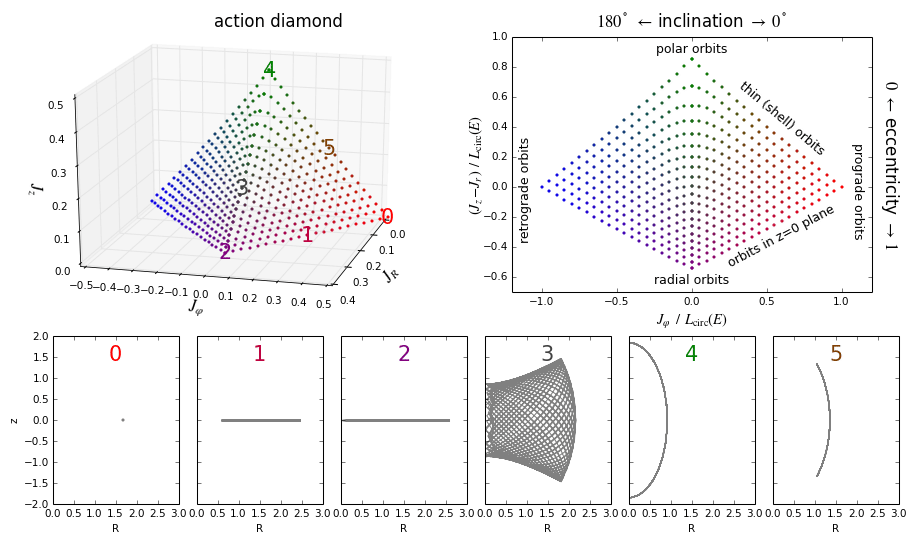

In [14]:
import mpl_toolkits.mplot3d
# for this example, use a truly Stäckel potential to avoid complications from the approximated actions
a = 2.0  # major axis of the profile
q = 0.6  # axis ratio z/R
pot = agama.Potential(type='PerfectEllipsoid', scaleRadius=a, axisRatioZ=q)
af = agama.ActionFinder(pot)
# plot the surface of constant energy E
E = -0.25
Rcirc = pot.Rcirc(E=E)
vcirc = (-pot.force(Rcirc,0,0)[0] * Rcirc)**0.5
Lcirc = Rcirc * vcirc  # maximum allowed angular momentum at this energy

plt.figure(figsize=(12,7))
ax3d = plt.axes([0.0, 0.4, 0.5, 0.6], projection='3d')
ax3d.view_init(elev=20, azim=15)
ax3d.set_xlabel(r'$J_R$', fontsize=16)
ax3d.set_ylabel(r'$J_\varphi$', fontsize=16)
ax3d.set_zlabel(r'$J_z$', fontsize=16)
ax3d.set_xlim(0, 0.4)
ax3d.set_ylim(-0.5, 0.5)
ax3d.set_zlim(0, 0.5)
ax3d.set_xticks(numpy.linspace(0, 0.4, 5))
ax3d.set_yticks(numpy.linspace(-0.5, 0.5, 11))
axd = plt.axes([0.56, 0.42, 0.40, 0.56], aspect='equal')
axd.set_xlim(-1.2, 1.2)
axd.set_ylim(-0.7, 1.0)
axd.set_xlabel(r'$J_\varphi\,/\,L_{\rm circ}(E)$', fontsize=14)
axd.set_ylabel(r'$(J_z-J_r)\,/\,L_{\rm circ}(E)$', fontsize=14, labelpad=0)
axd.text(0.5, 1.02, r'$180^\circ\,\leftarrow$ inclination $\rightarrow\,0^\circ$',
    ha='center', va='bottom', transform=axd.transAxes, fontsize=16)
axd.text(1.02, 0.5, r'$0\,\leftarrow$ eccentricity $\rightarrow\,1$',
    ha='left', va='center', transform=axd.transAxes, rotation=-90, fontsize=16)
axd.text(0.50, 0.98, 'polar orbits',  ha='center', va='top',    transform=axd.transAxes, fontsize=12)
axd.text(0.50, 0.02, 'radial orbits', ha='center', va='bottom', transform=axd.transAxes, fontsize=12)
axd.text(0.02, 0.40, 'retrograde orbits',ha='left',va='center', transform=axd.transAxes, fontsize=12, rotation=90)
axd.text(0.98, 0.40, 'prograde orbits',ha='right', va='center', transform=axd.transAxes, fontsize=12, rotation=-90)
axd.text(0.75, 0.68, 'thin (shell) orbits', ha='center', va='center', transform=axd.transAxes, fontsize=12, rotation=-40)
axd.text(0.75, 0.22, 'orbits in z=0 plane', ha='center', va='center', transform=axd.transAxes, fontsize=12, rotation=28)
axd.text(0.30, 0.99, 'action diamond', ha='center', va='top', transform=plt.gcf().transFigure, fontsize=16)
axo = [plt.axes([0.05+i*0.16, 0.05, 0.14, 0.325]) for i in range(6)]

# auxiliary routine for showing the meridional cross-section of an orbit
def showOrbit(ic, ind, color):
    if ic[3]==ic[5]==0:
        axo[ind].plot(R, 0, 'o', color='gray', ms=3, mew=0)
    else:
        orb = agama.orbit(potential=pot, ic=ic, time=1000, trajsize=1001)[1]
        axo[ind].plot((orb[:,0]**2 + orb[:,1]**2)**0.5, orb[:,2], color='gray')
    axo[ind].set_xlim(0, 3)
    axo[ind].set_ylim(-2, 2)
    axo[ind].set_aspect('equal')
    axo[ind].set_xlabel('R')
    if ind==0:
        axo[ind].set_ylabel('z')
    else:
        axo[ind].set_yticklabels([])
    axo[ind].text(0.5, 0.95, str(ind), ha='center', va='top', color=color, fontsize=20, transform=axo[ind].transAxes)
    ax3d.text( Jr, Jphi, Jz, str(ind), ha='center', va='center', color=color, fontsize=20)

# Plot a 2d grid of orbits in the action space, covering the available range of eccentricity and inclination.
# For each choice of Lz / Lcirc (ranging from -1 to 1, or rather from 0 to 1 due to symmetry),
# determine the radius R along the x axis corresponding to a thin orbit (with zero radial action),
# and the corresponding azimuthal and meridional velocity components.
# A thin orbit has initial velocity {vx=0, vy=vphi, vz=vmer}.
# By splitting the meridional velocity into vR(=vx) and vz in different proportions,
# we explore a grid of orbits with the same z-component angular momentum, but different eccentricities.
nL = 20  # number of grid nodes along the horizontal axis (Lz/Lcirc)
for iL in range(nL+1):
    Lz = Lcirc * iL/nL
    def findThinOrbit(R):
        # compute the radial action for an orbit with the given E and Lz,
        # launched vertically from the radius R along the x axis.
        # This function is to be minimized.
        vphi  = Lz/R if Lz>0 else 0
        vmer2 = 2 * (E - pot.potential(R, 0, 0)) - vphi**2
        if vmer2<0: return Lcirc  # outside the available range - return a large number
        return af([R, 0, 0, 0, vphi, vmer2**0.5])[0]  # Jr
    if iL<nL:
        R = abs(scipy.optimize.minimize_scalar(findThinOrbit, bounds=[0.5,2], method='Bounded').x)
        vphi = Lz/R
        vmer = (2*(E-pot.potential(R,0,0)) - vphi**2)**0.5
    else:
        R = Rcirc
        vphi = vcirc
        vmer = 0
    ne = nL-iL  # number of grid nodes along the vertical axis (eccentricity)
    for ie in range(ne+1):
        fracR = ie/(ne+1e-100)
        vR = vmer * (1-fracR)**0.5
        vz = vmer * (  fracR)**0.5
        ic = [R,0,0,vR,vphi,vz]
        Jr, Jz, Jphi = af(ic)
        fg = ie * 0.5 / nL
        fr = (nL + iL - ie) * 0.5 / nL
        fb = (nL - iL - ie) * 0.5 / nL
        colorpos = (fr, fg, fb)
        colorneg = (fb, fg, fr)
        ax3d.plot([Jr], [ Jphi], [Jz], 'o', color=colorpos, ms=3, mew=0)
        ax3d.plot([Jr], [-Jphi], [Jz], 'o', color=colorneg, ms=3, mew=0)
        axd.plot( Jphi/Lcirc, (Jz-Jr)/Lcirc, 'o', color=colorpos, ms=3, mew=0)
        axd.plot(-Jphi/Lcirc, (Jz-Jr)/Lcirc, 'o', color=colorneg, ms=3, mew=0)
        # pick up and show six example orbits along the edges of one face of the tetrahedron
        if iL==0 and ie%(nL//2)==0:
            showOrbit(ic, 2 + ie//(nL//2), colorpos)
        elif iL==nL//2 and ie%(nL//2)==0:
            showOrbit(ic, 1 + ie//(nL//2) * 4, colorpos)
        elif iL==nL:
            showOrbit(ic, 0, colorpos)
